In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [ ]:
df = pd.read_csv('/amazon.csv', encoding='latin1')

In [ ]:
month_map = {
   'Janeiro': 'January', 'Fevereiro': 'February', 'Março': 'March',
   'Abril': 'April', 'Maio': 'May', 'Junho': 'June',
   'Julho': 'July', 'Agosto': 'August', 'Setembro': 'September',
   'Outubro': 'October', 'Novembro': 'November', 'Dezembro': 'December'
}
df['month'] = df['month'].map(month_map)
df['date'] = pd.to_datetime(df['month'] + ' ' + df['year'].astype(str), format='%B %Y')
df.set_index('date', inplace=True)

In [ ]:
top_states = df.groupby('state')['number'].sum().sort_values(ascending=False).head(3).index.tolist()
df = df[df['state'].isin(top_states)]

In [ ]:
df_pivot = df.pivot_table(index='date', columns='state', values='number', aggfunc='sum').fillna(0)

In [ ]:
train = df_pivot[:-12]
test = df_pivot[-12:]

In [ ]:
from statsmodels.tools.sm_exceptions import EstimationWarning
import warnings

model = VAR(train)
results = None

for lag in reversed(range(1, 10)):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=EstimationWarning)
            results = model.fit(maxlags=lag, ic='aic')
            print(f"Model fitted successfully with lag = {lag}")
            break
    except ValueError:
        continue

if results is None:
    raise RuntimeError("VAR model could not be fitted with any reasonable lag value.")

Model fitted successfully with lag = 9


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast = results.forecast(train.values, steps=12)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

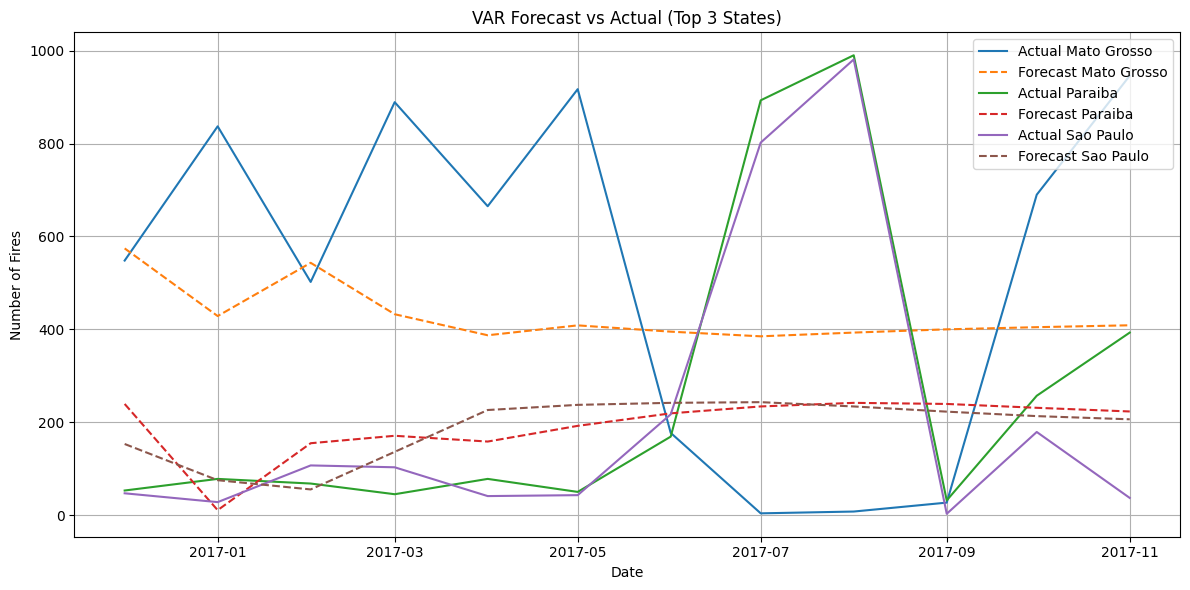

In [ ]:
plt.figure(figsize=(12, 6))
for state in top_states:
    plt.plot(test.index, test[state], label=f'Actual {state}')
    plt.plot(test.index, forecast_df[state], '--', label=f'Forecast {state}')
plt.title('VAR Forecast vs Actual (Top 3 States)')
plt.xlabel('Date')
plt.ylabel('Number of Fires')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()